In [1]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan

# Wave model WAM output from IFS

### Load wave data with open_zarr(), time, lon, lat

In [22]:
# json file was already prepared with gribscan-index and gribscan-build command line tools
resolution='tco2559-ng5'
gribfiles='wam_output/01May-31May2020' 
datapath='/work/bm1235/a270046/cycle2-sync/'+resolution+'/'+gribfiles
datazarr=datapath+'/json.dir/atm2d.json' # all wave data, this is the whole May
data = xr.open_zarr("reference::"+datazarr, consolidated=False)

In [5]:
datapath

'/work/bm1235/a270046/cycle2-sync/tco2559-ng5/wam_output/01May-31May2020'

In [3]:
data

<xarray.Dataset>
Dimensions:  (time: 745, cell: 2612294)
Coordinates:
  * time     (time) datetime64[ns] 2020-05-01 2020-05-01T01:00:00 ... 2020-06-01
Dimensions without coordinates: cell
Data variables:
    cdww     (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    dwi      (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwd      (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwp      (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    pp1d     (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    swh      (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    wind     (time, cell) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

### No latitude longitude information available; also pl does not seem to be available

Follow different route here: interpolate example file "source "with metview macro, resulting in "output.nc" on regular Gaussian grid. Convert to netcdf and plot

In [15]:
!grib_get -p jDirectionIncrementInDegrees /work/bm1235/a270046/cycle2-sync/tco2559-ng5/wam_output/01May-31May2020/MPP20200120000000_000133000000

0.125
0.125
0.125
0.125
0.125
0.125
0.125


Try the approach in https://confluence.ecmwf.int/display/OIFS/How+to+convert+GRIB+to+netCDF?focusedCommentId=149332094#comment-149332094

In [12]:
%%bash
cat << EOF > macro_interpolate
#Metview Macro to interpolate an input file called input
# to a regular lat-lon grid over a specific area (see below)
# and write the result to file output
## To excecute with metview batch: metview -b this_file
## specify target grid spacings:
gridx=0.125
gridy=gridx
# north, west, south and east boundaries of the target area:
north=90
west=0
south=-90
east=360
# macro:
read_interpolate = read(
source : "/work/bm1235/a270046/cycle2-sync/tco2559-ng5/wam_output/01May-31May2020/MPP20200120000000_000133000000",
area : [north,west,south,east],
grid : [gridx,gridy]
)
# write result to a file
write ("output", read_interpolate)
### end of macro
EOF

In [13]:
!metview -b macro_interpolate

metview: EXIT (OK) (line 1), exit status 0, starting 'cleanup'


In [16]:
!ls -lhrt output

-rw-r--r-- 1 a270046 bm0944 37M Jun 19 14:00 output


In [17]:
!grib_ls output

output
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         meanSea      0            20200120     3192         fc           swh          grid_simple  regular_ll  
1            ecmf         meanSea      0            20200120     3192         fc           mwd          grid_simple  regular_ll  
1            ecmf         meanSea      0            20200120     3192         fc           mwp          grid_simple  regular_ll  
1            ecmf         heightAboveGround  10           20200120     3192         fc           dwi          grid_simple  regular_ll  
1            ecmf         meanSea      0            20200120     3192         fc           pp1d         grid_simple  regular_ll  
1            ecmf         heightAboveGround  10           20200120     3192         fc           cdww         grid_simple  regular_ll  
1            ecmf         heightAboveGround  10           20200120    

Question is, how does MIR do it and know the lons/lats? https://confluence.ecmwf.int/display/UDOC/Differences+affecting+all+wave+fields

In [19]:
!grib_to_netcdf -o output.nc output

grib_to_netcdf: Version 2.22.1
grib_to_netcdf: Processing input file 'output'.
grib_to_netcdf: Found 7 GRIB fields in 1 file.
grib_to_netcdf: Ignoring key(s): method, type, stream, refdate, hdate
grib_to_netcdf: Creating netCDF file 'output.nc'
grib_to_netcdf: NetCDF library version: 4.8.0 of May 15 2021 07:14:51 $
grib_to_netcdf: Creating large (64 bit) file format.
grib_to_netcdf: Defining variable 'swh'.
grib_to_netcdf: Defining variable 'mwd'.
grib_to_netcdf: Defining variable 'mwp'.
grib_to_netcdf: Defining variable 'dwi'.
grib_to_netcdf: Defining variable 'pp1d'.
grib_to_netcdf: Defining variable 'cdww'.
grib_to_netcdf: Defining variable 'wind'.
grib_to_netcdf: Done.


In [23]:
datanc = xr.open_mfdataset('output.nc')

In [24]:
datanc

<xarray.Dataset>
Dimensions:    (longitude: 2880, latitude: 1441, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
  * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
  * time       (time) datetime64[ns] 2020-06-01
Data variables:
    swh        (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    mwd        (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    mwp        (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    dwi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    pp1d       (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    cdww       (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
    wind       (time, latitude, longitude) float32 dask.array<chunksize=(1, 1441, 2880), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-19 12:34:39 GMT by grib_to_netcdf-2.22.1: grib_to_n...

In [28]:
model_lon = datanc.longitude.values
model_lat = datanc.latitude.values
data_sample = datanc.swh.sel(time='2020-06-01')

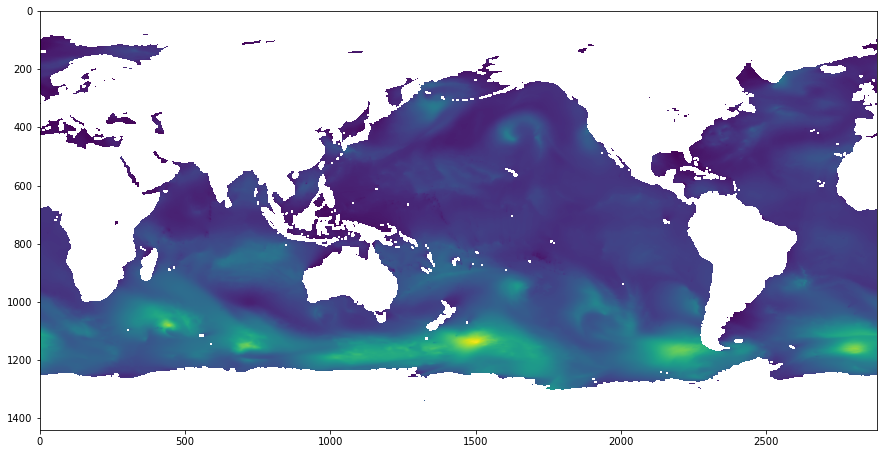

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(data_sample)

In [35]:
data_sample, np.shape(model_lon), np.shape(model_lat)

(<xarray.DataArray 'swh' (latitude: 1441, longitude: 2880)>
 dask.array<getitem, shape=(1441, 2880), dtype=float32, chunksize=(1441, 2880), chunktype=numpy.ndarray>
 Coordinates:
   * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
   * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
     time       datetime64[ns] 2020-06-01
 Attributes:
     units:      m
     long_name:  Significant height of combined wind waves and swell,
 (2880,),
 (1441,))

In [45]:
LON, LAT = np.meshgrid(model_lon, model_lat)

In [46]:
np.min(LAT), np.max(LAT), np.min(LON), np.max(LON)

(-90.0, 90.0, 0.0, 359.875)

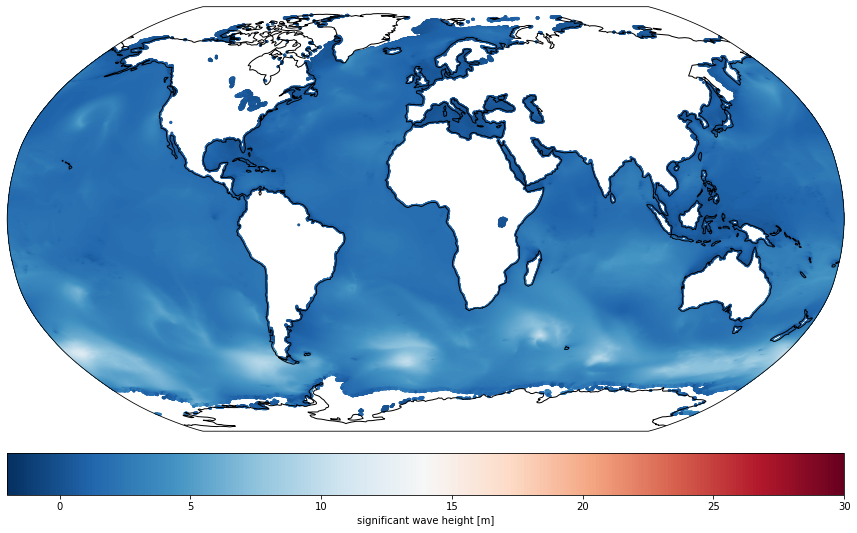

In [56]:
# sstep controls the spacing between points to plot
sstep=1 # (10 with s=4 e.g.)

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')

sc=ax.scatter(LON[::sstep], LAT[::sstep], s=4 , c=data_sample[::sstep],cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=-2.,vmax=30.)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label('significant wave height [m]')
#plt.clim(-20, 29.) 